#### Imports

In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

In [2]:
%matplotlib inline
warnings.filterwarnings("ignore")
pd.set_option('display.float_format', lambda x: '%.3f' % x)

#### Data Cleaning

In [3]:
jordan = pd.read_csv("jordan_career.csv")
lebron = pd.read_csv("lebron_career.csv")

###
pd.set_option('display.max_rows', jordan.shape[0] + 1)
pd.set_option('display.max_rows', lebron.shape[0] + 1)
pd.set_option('display.max_columns', jordan.shape[1] + 1)
pd.set_option('display.max_columns', lebron.shape[1] + 1)
###

jordan.drop(["game", "date", "team", "opp", "minus_plus"], axis=1, inplace=True) 
lebron.drop(["game", "date", "team", "opp", "minus_plus"], axis=1, inplace=True) 

jordan["threep"] = jordan["threep"].fillna(0)
lebron["threep"] = lebron["threep"].fillna(0)

jordan["ftp"] = jordan["ftp"].fillna(0)
lebron["ftp"] = lebron["ftp"].fillna(0)

jordan["result"] = [int(res.split(" ")[1][1:-1]) for res in jordan["result"]]
lebron["result"] = [int(res.split(" ")[1][1:-1]) for res in lebron["result"]]

t_age = lambda a, b: a + b / 365
jordan["age"] = [t_age(*[int(i) for i in age.split("-")]) for age in jordan["age"]]
lebron["age"] = [t_age(*[int(i) for i in age.split("-")]) for age in lebron["age"]]

t_time = lambda a, b: a + b / 60
jordan["mp"] = [t_time(*[int(i) for i in m.split(":")]) for m in jordan["mp"]]
lebron["mp"] = [t_time(*[int(i) for i in m.split(":")]) for m in lebron["mp"]]

#### Utilities

In [4]:
def split_df(x, s1=0.6, s2=0.8):
    size = x.shape[0]
    return x[int(size * s1):], x[int(size * s1):int(size * s2)], x[:int(size * s2)]


def standarize(x_train):
    mean = x_train.mean(0)
    std = x_train.std(0)
    return (x_train - mean[None, :]) / std[None, :]


def round_lst(lst, decimals):
    return [round(num, decimals) for num in lst]


def print_info_regr_train_cv(regressor, X_train, y_train, X_cv, y_cv):
    print('\nCoefs (per dim) ', regressor.coef_, ' and intercept: ', regressor.intercept_)
    print('\nTraining R2 Score:', regressor.score(X_train, y_train))
    print('Cross validation R2 Score:', regressor.score(X_cv, y_cv))
    print('\nTraining MSE: ', np.mean((regressor.predict(X_train) - y_train)**2))
    print('Cross validation MSE: ', np.mean((regressor.predict(X_cv) - y_cv)**2))


def print_info_regr_test(regressor, X_test, y_test):
    print('Testing R2 Score:', regressor.score(X_test, y_test))
    print('Testing MSE: ', np.mean((regressor.predict(X_test) - y_test)**2))


def mse(v1, v2):
    return ((v1 - v2)**2).mean()

In [5]:
X_jordan = jordan[["age", "result", "mp", "fg", "fga", "fgp", "three", "threeatt", "threep", "ft", "fta", "ftp", "orb", "drb", "trb", "ast", "stl", "blk", "tov", "pts"]]
y_jordan = jordan["game_score"]
X_lebron = lebron[["age", "result", "mp", "fg", "fga", "fgp", "three", "threeatt", "threep", "ft", "fta", "ftp", "orb", "drb", "trb", "ast", "stl", "blk", "tov", "pts"]]
y_lebron = lebron["game_score"]

X_train_j, X_test_j, X_cross_j = split_df(X_jordan)
y_train_j, y_test_j, y_cross_j = split_df(y_jordan)

X_train_l, X_test_l, X_cross_l = split_df(X_lebron)
y_train_l, y_test_l, y_cross_l = split_df(y_lebron)

js = standarize(jordan)
ls = standarize(lebron)

#### Jordan's linear regression with all attributes

In [6]:
regr_jordan = LinearRegression()
regr_jordan.fit(X_train_j, y_train_j) 

# print_info_regr_test(regr_jordan, X_test_j, y_test_j)
print_info_regr_train_cv(regr_jordan, X_train_j, y_train_j, X_cross_j, y_cross_j)


Coefs (per dim)  [ 0.00464374 -0.00328273 -0.00940925  0.30248009 -0.69868202  0.04646952
  0.07968736 -0.04312301 -0.06229749  0.35970956 -0.40964839 -0.03023663
  0.39693622 -0.04795447  0.34898175  0.66496453  1.00324258  0.63337203
 -1.04282229  1.04435709]  and intercept:  -0.29978830416428437

Training R2 Score: 0.9971771029353605
Cross validation R2 Score: 0.9961401183081939

Training MSE:  0.2221873312982712
Cross validation MSE:  0.30190245285920253


Text(0, 0.5, 'Predicted game_score')

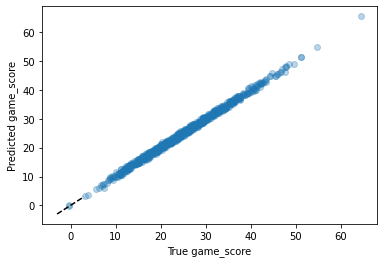

In [7]:
# Visualization of target and predicted responses
clf = LinearRegression()
clf.fit(X_train_j, y_train_j)
predicted = clf.predict(X_cross_j)

plt.scatter(y_cross_j, predicted, alpha=0.3)
plt.plot([-3, 3], [-3, 3], '--k')
plt.axis('tight')
plt.xlabel('True game_score')
plt.ylabel('Predicted game_score')

#### Jordan's info on standardised linear regresion with all attributes

In [8]:
X_jordan = js[["age", "result", "mp", "fg", "fga", "fgp", "three", "threeatt", "threep", "ft", "fta", "ftp", "orb", "drb", "trb", "ast", "stl", "blk", "tov", "pts"]]
y_jordan = js["game_score"]

X_train_j, X_test_j, X_cross_j = split_df(X_jordan)
y_train_j, y_test_j, y_cross_j = split_df(y_jordan)

regr_jordan = LinearRegression()
regr_jordan.fit(X_train_j, y_train_j) 

# print_info_regr_test(regr_jordan, X_test_j, y_test_j)
print_info_regr_train_cv(regr_jordan, X_train_j, y_train_j, X_cross_j, y_cross_j)


Coefs (per dim)  [ 2.62129871e-03 -4.43348106e-03 -5.66170769e-03  5.19671745e-01
 -4.37158241e-01  5.32758319e-04  5.85735800e-02 -7.96795011e-03
 -2.04022203e-03  3.66330036e-01 -1.99934863e-01 -6.70093470e-04
  8.31526424e-02  2.76218208e-02  6.32914731e-02  1.90838190e-01
  1.75155794e-01  6.75085565e-02 -1.90548448e-01  5.66670913e-01]  and intercept:  0.009501054099808781

Training R2 Score: 0.9971771029353605
Cross validation R2 Score: 0.9961401183081938

Training MSE:  0.002468598759062118
Cross validation MSE:  0.003354268743097578


#### Jordan's regresion with most important/relevant attributes

In [9]:
X_jordan = js[["fg", "fga", "fgp", "threep", "ft", "fta", "ftp", "orb", "trb", "ast", "stl", "blk", "tov", "pts"]]
y_jordan = js["game_score"]

X_train_j, X_test_j, X_cross_j = split_df(X_jordan)
y_train_j, y_test_j, y_cross_j = split_df(y_jordan)

regr_jordan = LinearRegression()
regr_jordan.fit(X_train_j, y_train_j) 

# print_info_regr_test(regr_jordan, X_test_j, y_test_j)
print_info_regr_train_cv(regr_jordan, X_train_j, y_train_j, X_cross_j, y_cross_j)


Coefs (per dim)  [ 1.26077459e-01 -4.45134047e-01 -4.31655823e-03  4.37455464e-04
  1.51040083e-01 -1.99527612e-01 -1.07474804e-03  6.62758797e-02
  9.46286742e-02  1.89016325e-01  1.73765218e-01  6.79076615e-02
 -1.90806423e-01  1.07619461e+00]  and intercept:  0.009074958194991989

Training R2 Score: 0.9971087212443945
Cross validation R2 Score: 0.9961299382325804

Training MSE:  0.0025283979489000717
Cross validation MSE:  0.003363115312023471


Text(0, 0.5, 'Predicted game_score')

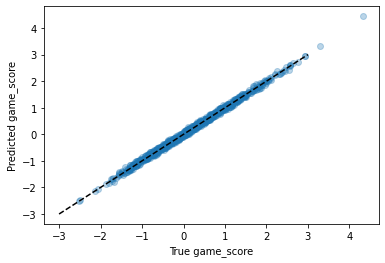

In [10]:
# Visualization of target and predicted responses
clf = LinearRegression()
clf.fit(X_train_j, y_train_j)
predicted = clf.predict(X_cross_j)

plt.scatter(y_cross_j, predicted, alpha=0.3)
plt.plot([-3, 3], [-3, 3], '--k')
plt.axis('tight')
plt.xlabel('True game_score')
plt.ylabel('Predicted game_score')

#### Jordan's regresion with important/relevant attributes

In [11]:
#X_jordan = js[["age", "result", "mp", "fgp", "three", "threeatt", "threep", "ftp", "trb"]]
X_jordan = js[["pts", "fg", "fga", "ft", "fta", "orb", "drb", "stl", "blk", "tov", "ast"]]
y_jordan = js["game_score"]

X_train_j, X_test_j, X_cross_j = split_df(X_jordan)
y_train_j, y_test_j, y_cross_j = split_df(y_jordan)

regr_jordan = LinearRegression()
regr_jordan.fit(X_train_j, y_train_j) 

# print_info_regr_test(regr_jordan, X_test_j, y_test_j)
print_info_regr_train_cv(regr_jordan, X_train_j, y_train_j, X_cross_j, y_cross_j)


Coefs (per dim)  [ 1.078115    0.1178023  -0.44043259  0.14777872 -0.19755116  0.11146924
  0.08041658  0.1736452   0.06781741 -0.19075937  0.18909332]  and intercept:  0.00907986845568548

Training R2 Score: 0.9971052831388775
Cross validation R2 Score: 0.9961274548390769

Training MSE:  0.0025314045420625005
Cross validation MSE:  0.003365273401278711


Text(0, 0.5, 'Predicted game_score')

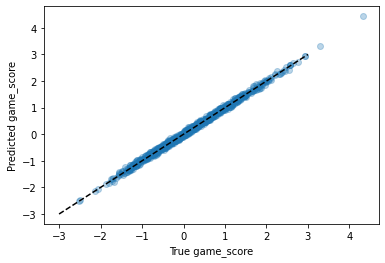

In [12]:
# Visualization of target and predicted responses
clf = LinearRegression()
clf.fit(X_train_j, y_train_j)
predicted = clf.predict(X_cross_j)

plt.scatter(y_cross_j, predicted, alpha=0.3)
plt.plot([-3, 3], [-3, 3], '--k')
plt.axis('tight')
plt.xlabel('True game_score')
plt.ylabel('Predicted game_score')

#### Lebron's standardised linear regresion with all attributes

In [13]:
X_lebron = ls[["age", "result", "mp", "fg", "fga", "fgp", "three", "threeatt", "threep", "ft", "fta", "ftp", "orb", "drb", "trb", "ast", "stl", "blk", "tov", "pts"]]
y_lebron = ls["game_score"]

X_train_l, X_test_l, X_cross_l = split_df(X_lebron)
y_train_l, y_test_l, y_cross_l = split_df(y_lebron)

regr_lebron = LinearRegression()
regr_lebron.fit(X_train_l, y_train_l) 

# print_info_regr_test(regr_lebron, X_test_l, y_test_l)
print_info_regr_train_cv(regr_lebron, X_train_l, y_train_l, X_cross_l, y_cross_l)


Coefs (per dim)  [-0.00352643  0.0034497  -0.01574006  0.50050619 -0.43176161  0.00228471
  0.07439334 -0.00109168  0.00173622  0.37452067 -0.21451181 -0.00374221
  0.07576704  0.04055516  0.06610044  0.25875697  0.17003223  0.08487917
 -0.24291615  0.57032204]  and intercept:  0.007851537056199905

Training R2 Score: 0.9955778343487951
Cross validation R2 Score: 0.9958030808855999

Training MSE:  0.0035802044589487232
Cross validation MSE:  0.004422270985382342


Text(0, 0.5, 'Predicted game_score')

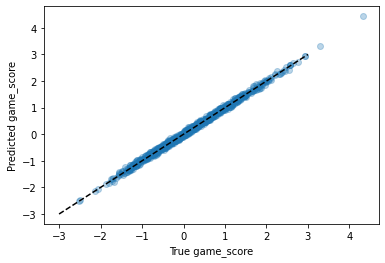

In [14]:
#Visualization of target and predicted responses
clf = LinearRegression()
clf.fit(X_train_j, y_train_j)
predicted = clf.predict(X_cross_j)

plt.scatter(y_cross_j, predicted, alpha=0.3)
plt.plot([-3, 3], [-3, 3], '--k')
plt.axis('tight')
plt.xlabel('True game_score')
plt.ylabel('Predicted game_score')

## Gradient Descent

In [15]:
class Regressor(object):
    def __init__(self, weights, alpha, beta):
        # Initialize the weights and the previous weights used in the train function
        self.prev = np.array(weights)
        self.weights = np.array(weights)
        # Initialize the specifications for the training process
        self.a = alpha
        self.b = beta
    
    def mse(self, X, y):
        return np.mean((self.predict(X) - y)**2)
    
    def predict(self, X):
        # Function that uses the weights to predict an output given a matrix of values
        return [self.weights[0] + np.dot(row, self.weights[1:]) for i, row in X.iterrows()]
    
    
    def __update(self, X, hy, y):
        # Procedure that updates the weights given a matrix, the predicction (hy)  
        # and its real value using a formula that modifies each weight separately
        m = X.shape[0]
        self.weights[0] -= self.a * np.sum(hy - y) / m
        # Except for the weight of the intercept, the other ones must be calculated
        # taking into account the predictions and their real values
        for j in range(1, len(self.weights)):
            self.weights[j] -= self.a * (sum([(hy[i] - y.iloc[i]) * X.iloc[i, j-1] for i in range(m)]) - self.b * self.prev[j]) / m 
    
    
    def __J(self, X, y):
        # Function that calculates the MSE (Minimum Square Error) 
        return 0.5 * (np.sum((self.predict(X) - y)**2) + self.b * np.sum(self.weights**2)) / X.shape[0]
        
    
    def train(self, max_iters, eps, X, y):
        # Procedure that trains the Regressor while the improvement is lesser than
        # the parameter given and it has not reached a maximum of iterations
        iters = 0
        improvement = self.__J(X, y)
        while improvement > eps and iters < max_iters:
            # Saves the previous weights and updates the Regressor
            self.prev = np.copy(self.weights)
            self.__update(X, self.predict(X), y)
            # Calculates the new improvment and increases the number of iterations
            improvement = self.__J(X, y)
            iters += 1

#### Jordan's gradient descent

In [16]:
X_jordan = js[["age", "result", "mp", "fg", "fga", "fgp", "three", "threeatt", "threep", "ft", "fta", "ftp", "orb", "drb", "trb", "ast", "stl", "blk", "tov", "pts"]]
y_jordan = js["game_score"]

X_train_j, X_test_j, X_cross_j = split_df(X_jordan)
y_train_j, y_test_j, y_cross_j = split_df(y_jordan)

In [17]:
weights = [0.009501054099808781, 2.62129871e-03, -4.43348106e-03, -5.66170769e-03, 5.19671745e-01, -4.37158241e-01,
           5.32758319e-04, 5.85735800e-02, -7.96795011e-03, -2.04022203e-03, 3.66330036e-01, -1.99934863e-01,
           -6.70093470e-04, 8.31526424e-02, 2.76218208e-02, 6.32914731e-02, 1.90838190e-01, 1.75155794e-01,
           6.75085565e-02, -1.90548448e-01, 5.66670913e-01]
weights = round_lst(weights, 3)
alpha, beta, iters, eps = 0.3, 0, 40, 0.001

descens = Regressor(weights, alpha, beta)
descens.train(iters, eps, X_train_j, y_train_j)
print(descens.mse(X_cross_j, y_cross_j)) # 0.003354268743097578

0.0033565568293468188


In [18]:
weights = [0.009501054099808781, 2.62129871e-03, -4.43348106e-03, -5.66170769e-03, 5.19671745e-01, -4.37158241e-01,
           5.32758319e-04, 5.85735800e-02, -7.96795011e-03, -2.04022203e-03, 3.66330036e-01, -1.99934863e-01,
           -6.70093470e-04, 8.31526424e-02, 2.76218208e-02, 6.32914731e-02, 1.90838190e-01, 1.75155794e-01,
           6.75085565e-02, -1.90548448e-01, 5.66670913e-01]
weights = round_lst(weights, 3)
alpha, beta, iters, eps = 0.3, 0.5, 40, 0.001

descens = Regressor(weights, alpha, beta)
descens.train(iters, eps, X_train_j, y_train_j)
print(descens.mse(X_cross_j, y_cross_j)) # 0.003354268743097578

0.0033670205760757133


#### Lebron's gradient descent

In [19]:
weights = [0.007851537056199905, -0.00352643, 0.0034497, -0.01574006, 0.50050619, -0.43176161, 0.00228471, 0.07439334, -0.00109168,
           0.00173622, 0.37452067, -0.21451181, -0.00374221, 0.07576704, 0.04055516, 0.06610044, 0.25875697, 
           0.17003223, 0.08487917, -0.24291615, 0.57032204] 
weights = round_lst(weights, 3)
alpha, beta, iters, eps = 0.2, 0, 40, 0.001

descens = Regressor(weights, alpha, beta)
descens.train(iters, eps, X_train_l, y_train_l)
print(descens.mse(X_cross_l, y_cross_l)) # 0.004422270985382342

0.004429315263418526


### MSE DE TODOS LOS ATRIBUTOS Y EL GAME_SCORE

#### JORDAN

In [20]:
attributes = ["age", "result", "mp", "fg", "fga", "fgp", "three", "threeatt", "threep", "ft", "fta", "ftp", "orb", "drb", "trb", "ast", "stl", "blk", "tov", "pts"]
y_j = js["game_score"]

regr = LinearRegression()
predictions_j = []
MSE_j = []
r2_j = []

for at in attributes:
    attribute_j = js[at].values.reshape(js.shape[0], 1)
    regr.fit(attribute_j, y_j)
    predictions_j.append(regr.predict(attribute_j))

for pred in predictions_j:
    MSE_j.append(mse(y_j, pred))
    r2_j.append(r2_score(y_j, pred))

print("Mean squeared error: ", MSE_j)
print("R2 score: ", r2_j)

Mean squeared error:  [0.8550817372885056, 0.9492526185454523, 0.8792564640088111, 0.34449340597285627, 0.7431720402603865, 0.5637520480378435, 0.9551591353609895, 0.9725312629851134, 0.9687155031729304, 0.6696396231555409, 0.7112903609603588, 0.8971273133295353, 0.9566308100425838, 0.9714828081367018, 0.9414759924801329, 0.9375920745117609, 0.8414519469787471, 0.9449743642372292, 0.9956987904504638, 0.19710941055257755]
R2 score:  [0.14411986706509994, 0.04986105781444927, 0.11992256823767922, 0.6551849381858993, 0.2561340549401184, 0.4357215728323358, 0.04394902604390327, 0.026560677945806854, 0.03038000055893575, 0.32973512976401564, 0.28804550238141513, 0.10203503278313564, 0.04247597724962715, 0.02761011174365735, 0.05764494496853256, 0.06153248937758504, 0.15776238360297334, 0.05414330675788048, 0.003371518802150364, 0.8027065470472801]


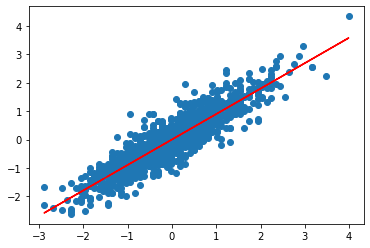

In [21]:
# EL MEJOR SON LOS PUNTOS !! GRAFICA
plt.figure()
pts = js[attributes[19]].values.reshape(js.shape[0], 1)
ax = plt.scatter(pts, y_j)
plt.plot(pts[:, 0], predictions_j[19], 'r')

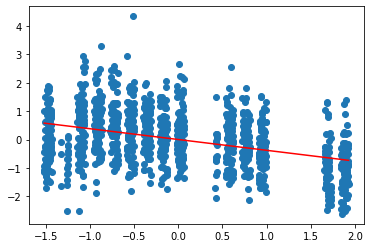

In [22]:
# EL PEOR SON LOS AÑOS !! GRAFICA
plt.figure()
age = js[attributes[0]].values.reshape(js.shape[0], 1)
ax = plt.scatter(age, y_j)
plt.plot(age[:,0], predictions_j[0], 'r')

#### LEBRON

In [23]:
attributes = ["age", "result", "mp", "fg", "fga", "fgp", "three", "threeatt", "threep", "ft", "fta", "ftp", "orb", "drb", "trb", "ast", "stl", "blk", "tov", "pts"]
y_l = ls["game_score"]

regr = LinearRegression()
predictions_l = []
MSE_l = []
r2_l = []

for at in attributes:
    attribute_l = ls[at].values.reshape(ls.shape[0], 1)
    regr.fit(attribute_l, y_l)
    predictions_l.append(regr.predict(attribute_l))

for pred in predictions_l:
    MSE_l.append(mse(y_l, pred))
    r2_l.append(r2_score(y_l, pred))

print("Mean squeared error: ", MSE_l)
print("R2 score: ", r2_l)

Mean squeared error:  [0.9889197904232003, 0.9260061477335992, 0.9195944799513003, 0.4483812175511008, 0.8310334643172256, 0.6260712793514422, 0.8236539839565951, 0.9071448866801878, 0.9011867511961745, 0.8130871423399292, 0.8647490877196193, 0.944954316575775, 0.9740755804869963, 0.9532286931365458, 0.934712645388159, 0.9246719410121056, 0.9419363045619767, 0.9729833652920331, 0.9674456320873327, 0.28333550718381173]
R2 score:  [0.010205833104276918, 0.07317510235682212, 0.07959243916456937, 0.5512223357490312, 0.16823175808390878, 0.373375165140732, 0.17561776318402622, 0.0920530400336228, 0.09801644354193895, 0.1861939477198954, 0.1344863242275779, 0.05421018004971101, 0.02506316789453622, 0.04592848750612599, 0.06446090664951687, 0.0745104887482747, 0.05723086050914461, 0.026156348797011897, 0.03169897831754187, 0.7164139751263707]


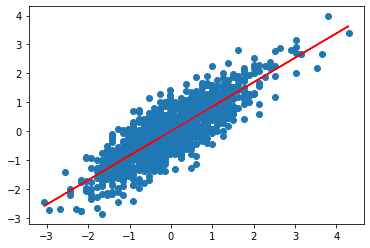

In [24]:
# EL MEJOR SON LOS PUNTOS !! GRAFICA
plt.figure()
pts = ls[attributes[19]].values.reshape(ls.shape[0], 1)
ax = plt.scatter(pts, y_l)
plt.plot(pts[:, 0], predictions_l[19], 'r')

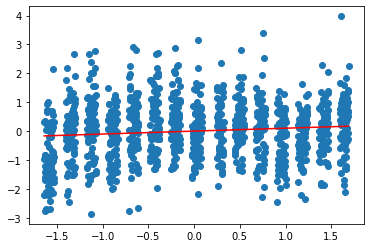

In [25]:
# EL PEOR SON LOS AÑOS !! GRAFICA
plt.figure()
age = ls[attributes[0]].values.reshape(ls.shape[0], 1)
ax = plt.scatter(age, y_l)
plt.plot(age[:,0], predictions_l[0], 'r')

### ANEM A PROVAR QUE EL MILLOR ES EL LINEAL (FER POLINOMIAL)

Text(0, 0.5, 'Predicted game_score')

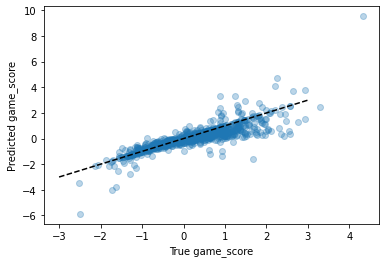

In [26]:
#fitting the polynomial regression model to the dataset

poly_reg = PolynomialFeatures(degree=3)
X_poly = poly_reg.fit_transform(X_train_j)
poly_reg.fit(X_poly,y_train_j)

lin_reg2 = LinearRegression()
lin_reg2.fit(X_poly,y_train_j)
predicted = lin_reg2.predict(poly_reg.fit_transform(X_cross_j))

plt.scatter(y_cross_j, predicted, alpha=0.3)
plt.plot([-3, 3], [-3, 3], '--k')
plt.axis('tight')
plt.xlabel('True game_score')
plt.ylabel('Predicted game_score')

Text(0, 0.5, 'Predicted game_score')

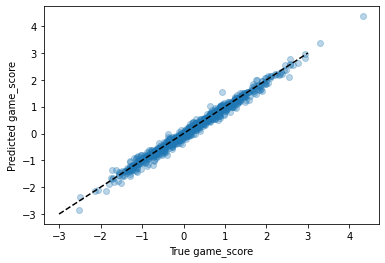

In [27]:
# Visualization of target and predicted responses
poly_reg = PolynomialFeatures(degree=2)
X_poly = poly_reg.fit_transform(X_train_j)
poly_reg.fit(X_poly,y_train_j)

lin_reg2 = LinearRegression()
lin_reg2.fit(X_poly,y_train_j)
predicted = lin_reg2.predict(poly_reg.fit_transform(X_cross_j))

plt.scatter(y_cross_j, predicted, alpha=0.3)
plt.plot([-3, 3], [-3, 3], '--k')
plt.axis('tight')
plt.xlabel('True game_score')
plt.ylabel('Predicted game_score')

In [28]:
features = pd.DataFrame(poly_reg.transform(X_train_j), columns=poly_reg.get_feature_names(X_train_j.columns))
print(features.head())

      1   age  result     mp     fg    fga    fgp  three  threeatt  threep  \
0 1.000 0.042  -0.146  0.480  0.948  0.861  0.370 -0.559     0.765  -0.608   
1 1.000 0.043  -0.536 -0.045 -0.098  0.356 -0.512  0.472     0.195   1.001   
2 1.000 0.043   0.791  0.831  2.516  2.040  0.959  1.503     1.336   1.001   
3 1.000 0.044  -0.536  0.831 -0.098  0.356 -0.512  0.472     0.765   0.464   
4 1.000 0.045   0.167 -0.045 -0.359 -0.150 -0.375 -0.559    -0.376  -0.608   

      ft    fta    ftp  ...  ast blk  ast tov  ast pts  stl^2  stl blk  \
0  0.286  0.176  0.398  ...    0.227   -0.577    1.111  4.869    0.364   
1 -0.205 -0.471  0.926  ...   -0.831   -1.005   -0.116  2.005    1.166   
2  0.286  0.176  0.398  ...   -0.015    0.147   -0.210  0.043   -0.034   
3 -0.450 -0.471  0.131  ...   -0.226   -0.431   -0.060  0.660    0.669   
4 -0.941 -0.903 -0.263  ...    0.380   -1.136    0.337  0.998   -0.823   

   stl tov  stl pts  blk^2  blk tov  blk pts  tov^2  tov pts  pts^2  
0   -0.926    1.